In [1]:
# Para tratamento dos dados
import pandas as pd
import numpy as np

# Para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

# Para calcular métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import math

In [2]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Tratando coluna TotalCHarges**

In [3]:
def total_charges_to_float(df_, to_print=False):
    
    if to_print:
        # Verificando porcentagem de valores nulos
        na_perc = (df['TotalCharges'].str.len() == 0).sum()/len(df)
        print(f'Porcentagem de valores nulos na coluna "TotalCharges": {na_perc*100:.3f}%')

    # Removendo espaços
    df_['TotalCharges'] = df_['TotalCharges'].str.strip()
    # Encontrando linhas nulas
    na_rows = df_['TotalCharges'].str.len() == 0
    # Substituindo linhas nulas por NaNs
    df_.loc[na_rows, 'TotalCharges'] = np.nan
    
    # Convertendo para float
    df_['TotalCharges'] = df_['TotalCharges'].astype(np.float64)
    
    return df_

In [4]:
df = total_charges_to_float(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Descrição dos dados:**

Como mostrado acima, o conjunto de dados contém 19 variáveis ​​independentes, que podem ser classificadas em 3 grupos:

### [1] Informações Demográficas

`gender`: se o cliente é do sexo feminino ou masculino (`female`, `male`).

`SeniorCitizen`: 

`Partner`: 

`Dependents`: 

### [2] Informações da conta do cliente

`tenure`: 

`Contract`: 

`PaperlessBilling`: 

`PaymentMethod`: 

`MonthlyCharges`: 

`TotalCharges`: 

### [3] Informações de serviços

`PhoneService`: 

`MultipleLines`: 

`InternetService`: 

`OnlineSecurity`: 

`OnlineBackup`: 

`DeviceProtection`: 

`TechSupport`: 

`StreamingTV`: 

`StreamingMovies`: 




## Ajustes para visualizações

In [6]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [7]:
# remove (automatic) from payment method names
df['PaymentMethod'] = df['PaymentMethod'].str.replace(' (automatic)', '', regex=False)
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

## Dataviz

In [8]:
churn_counts = df.groupby('Churn')['customerID'].count()
churn_percents = (churn_counts/churn_counts.sum()).round(3).to_frame().rename({'customerID': 'percentual'}, axis=1).reset_index()
churn_percents

,Churn,percentual
0,No,0.735
1,Yes,0.265


In [9]:
import matplotlib.ticker as mtick

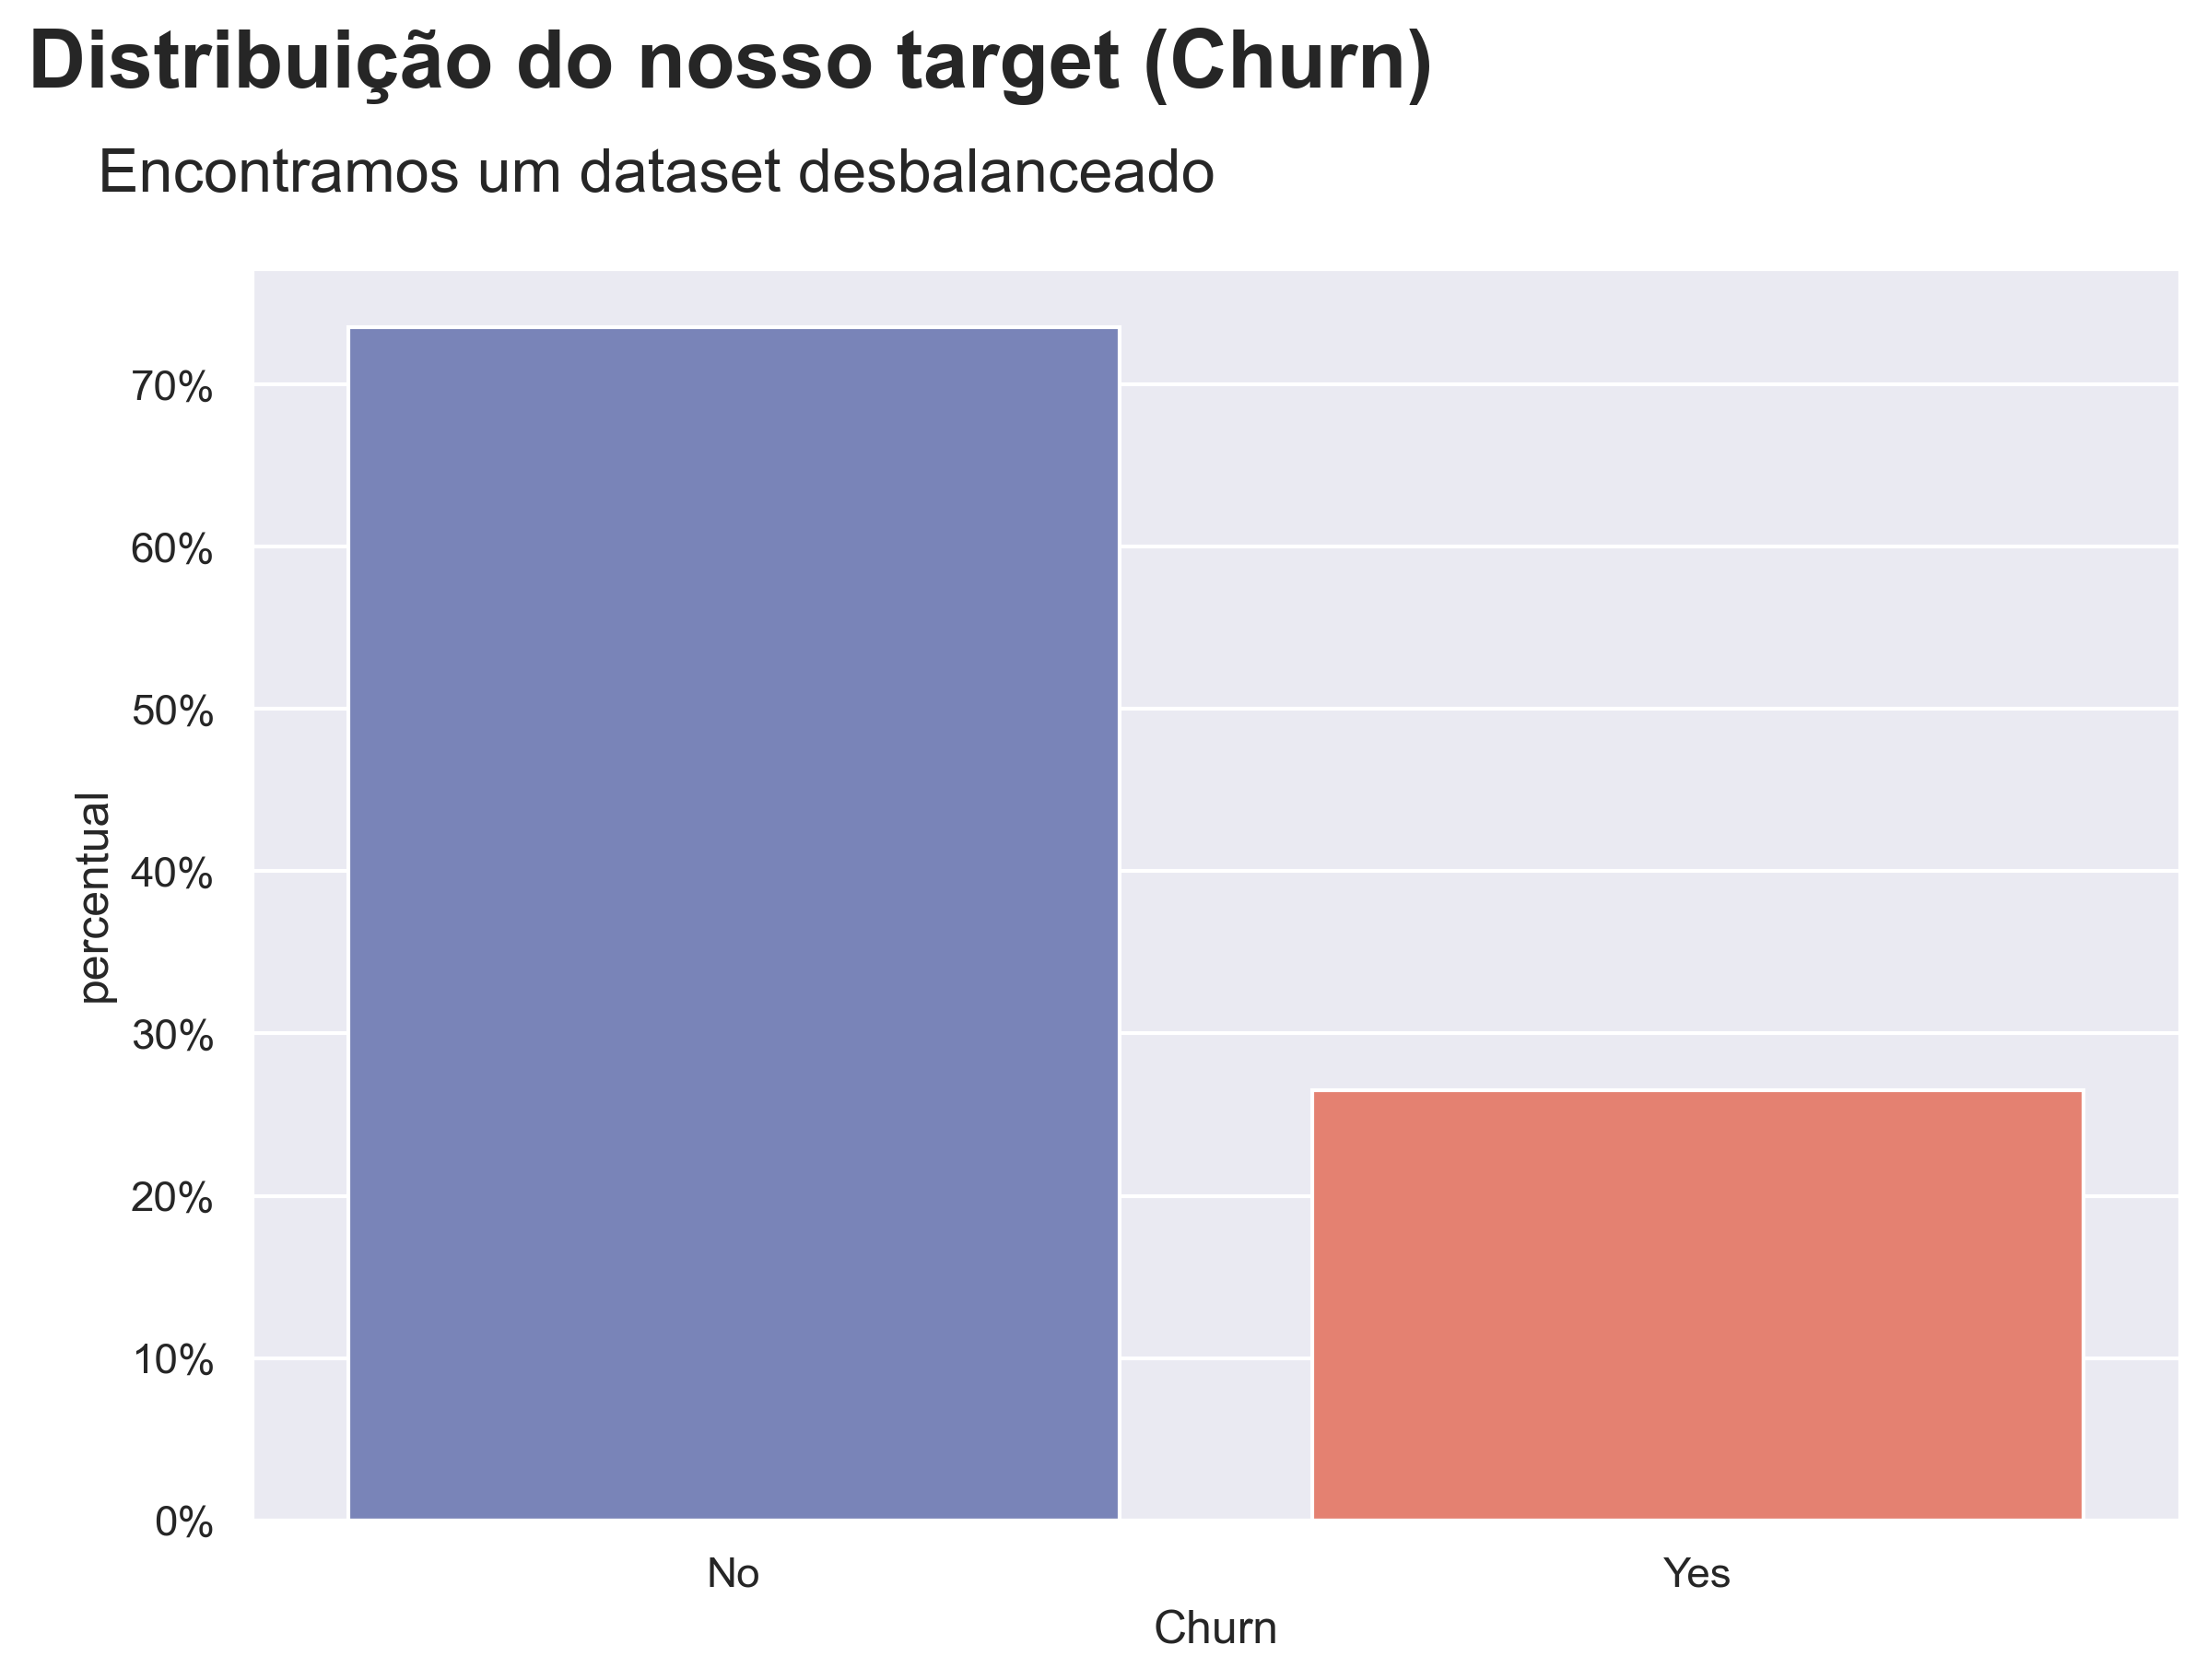

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9,6), dpi=300)
fig.suptitle('Distribuição do nosso target (Churn)', weight='bold', horizontalalignment='right', y=1.025, x=0.60, fontsize=21)
ax.set_title('Encontramos um dataset desbalanceado', pad=20, horizontalalignment='right', fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
sns.barplot(data=churn_percents, x='Churn', y='percentual', ax=ax, palette=['#6E7DC3', '#F7735E', '#3B499B', '#BD4120']);

In [11]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows), dpi=300) 
    fig.suptitle(super_title, fontsize=22,  y=.95, weight='bold')
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['#6E7DC3', '#F7735E', '#3B499B', '#BD4120'])

        # set the legend in the upper right corner
        ax.legend(bbox_to_anchor=(0.9,0.3),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proporção de observações por ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

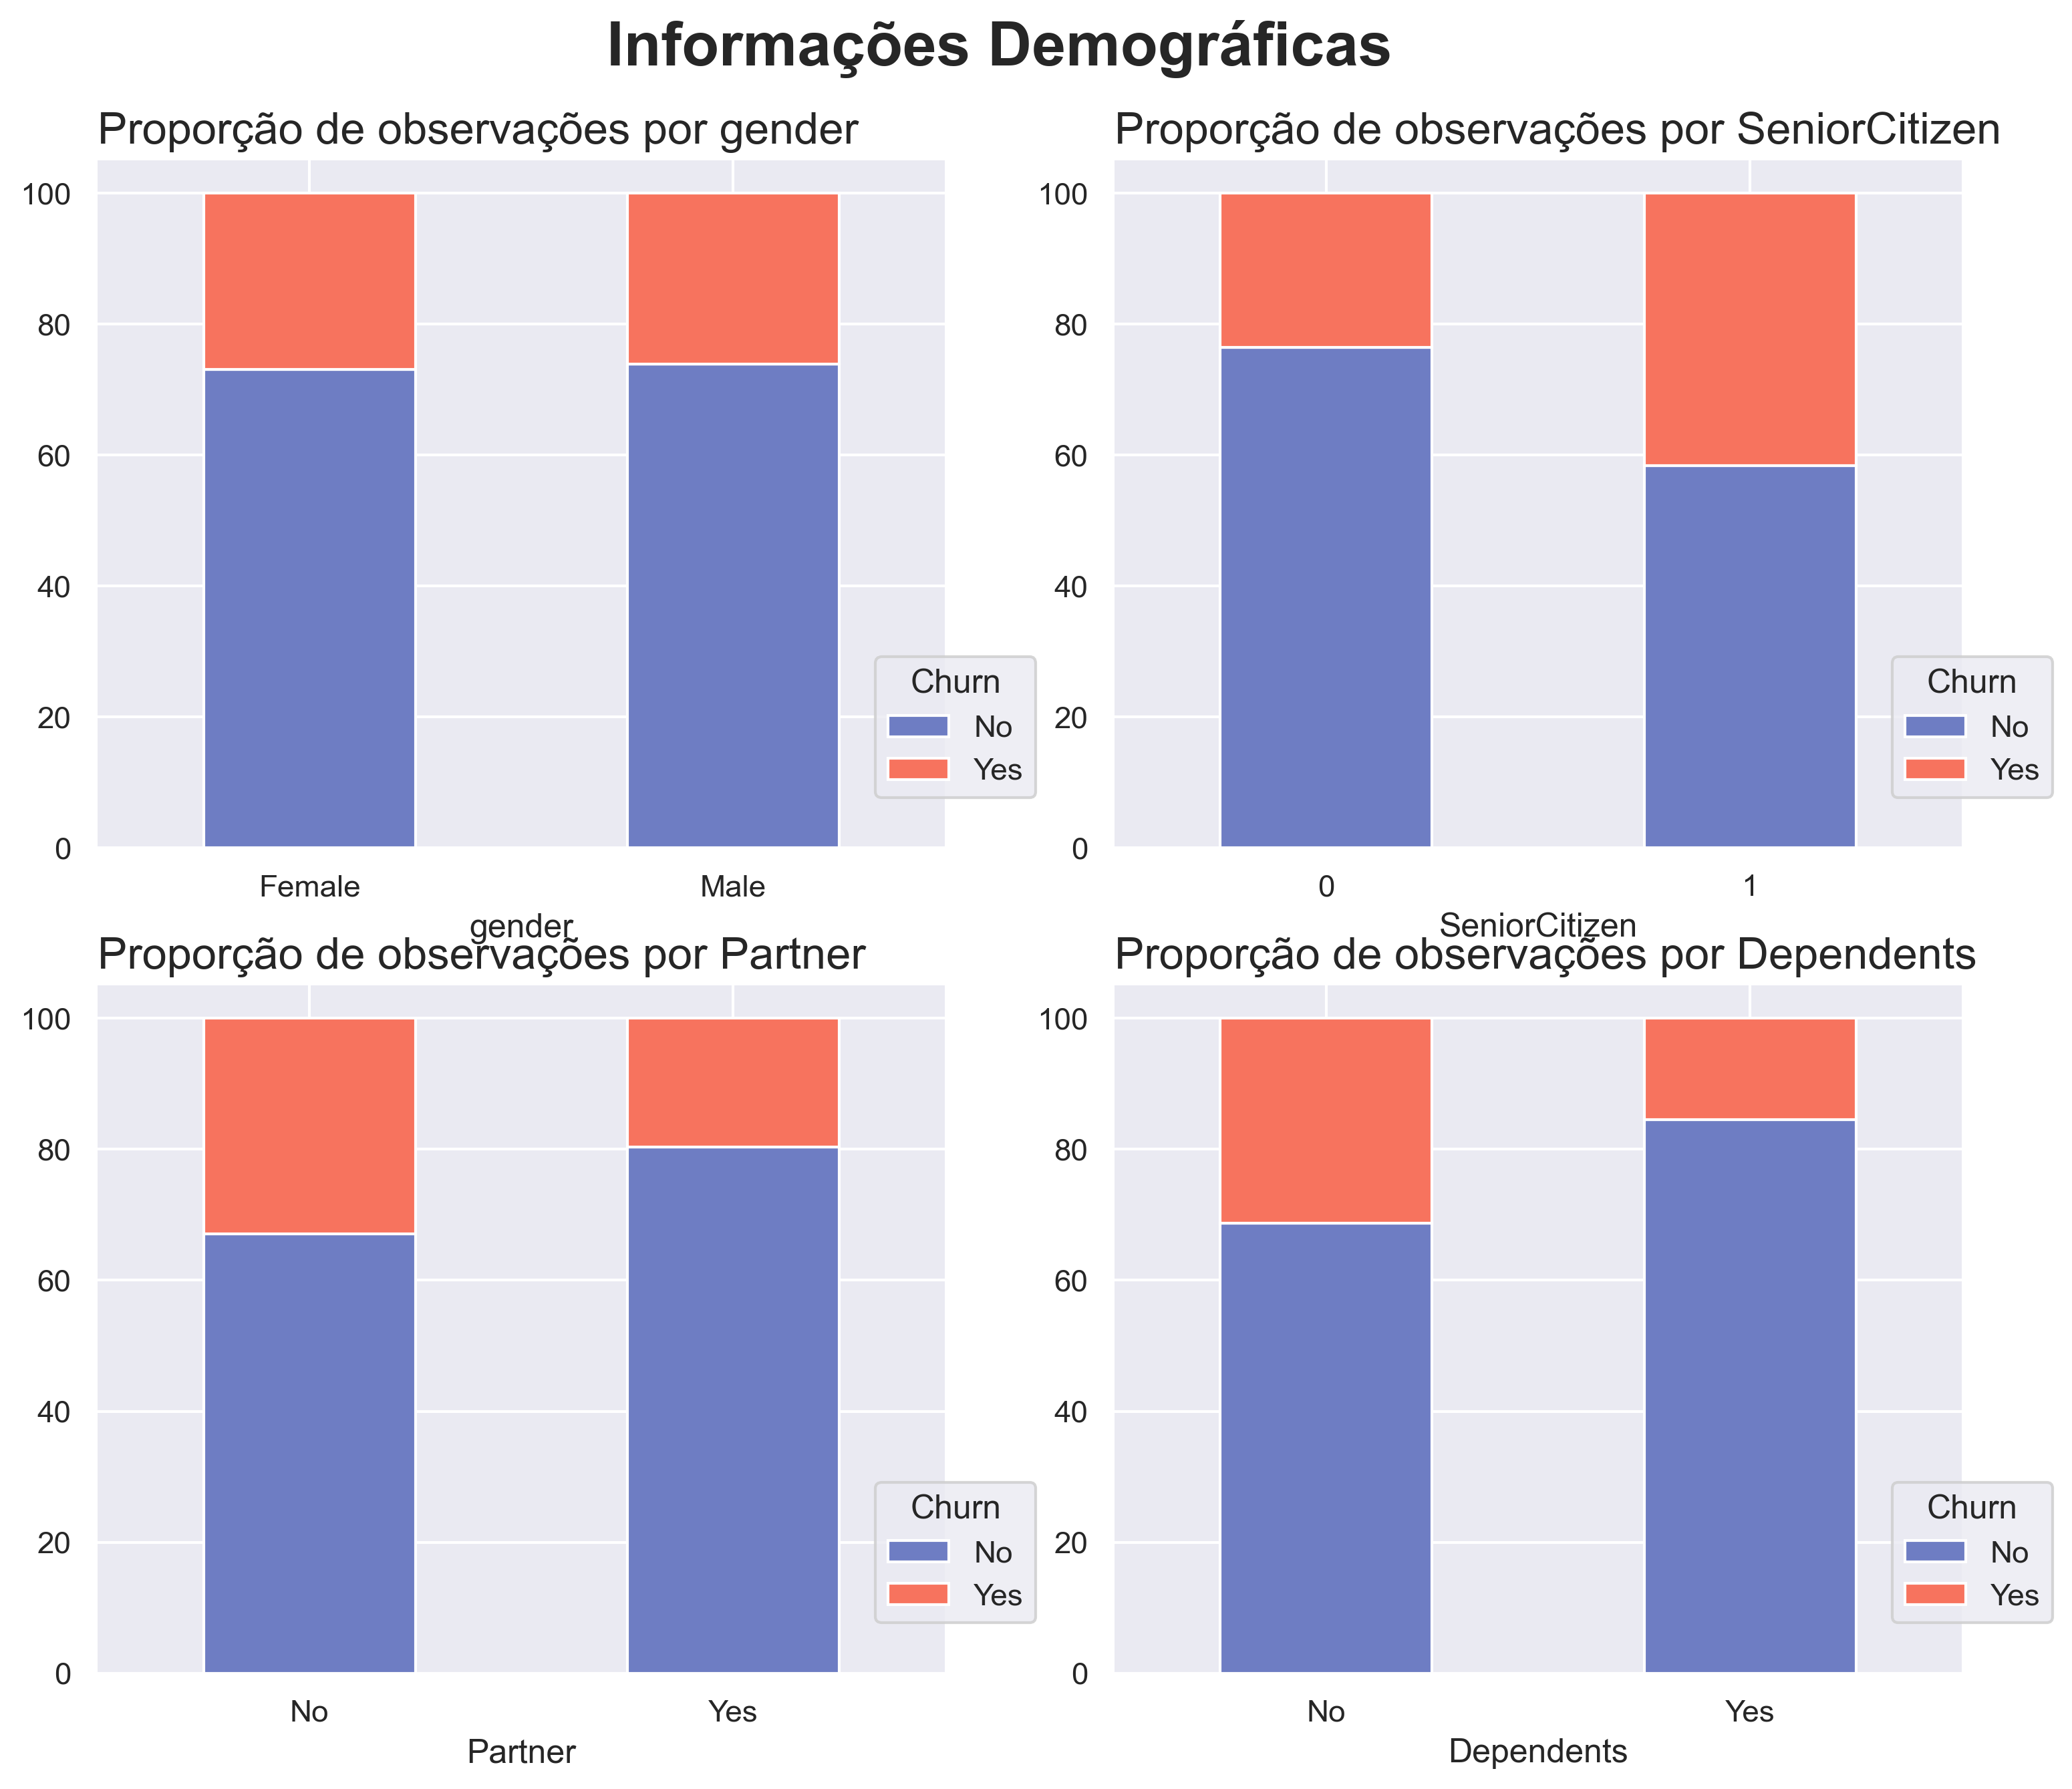

In [12]:
df_telco = df.copy()

# demographic column names
demographic_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Informações Demográficas')

In [13]:
# Colors
['#6E7DC3', '#F7735E', '##3B499B', '#BD4120']

['#6E7DC3', '#F7735E', '##3B499B', '#BD4120']

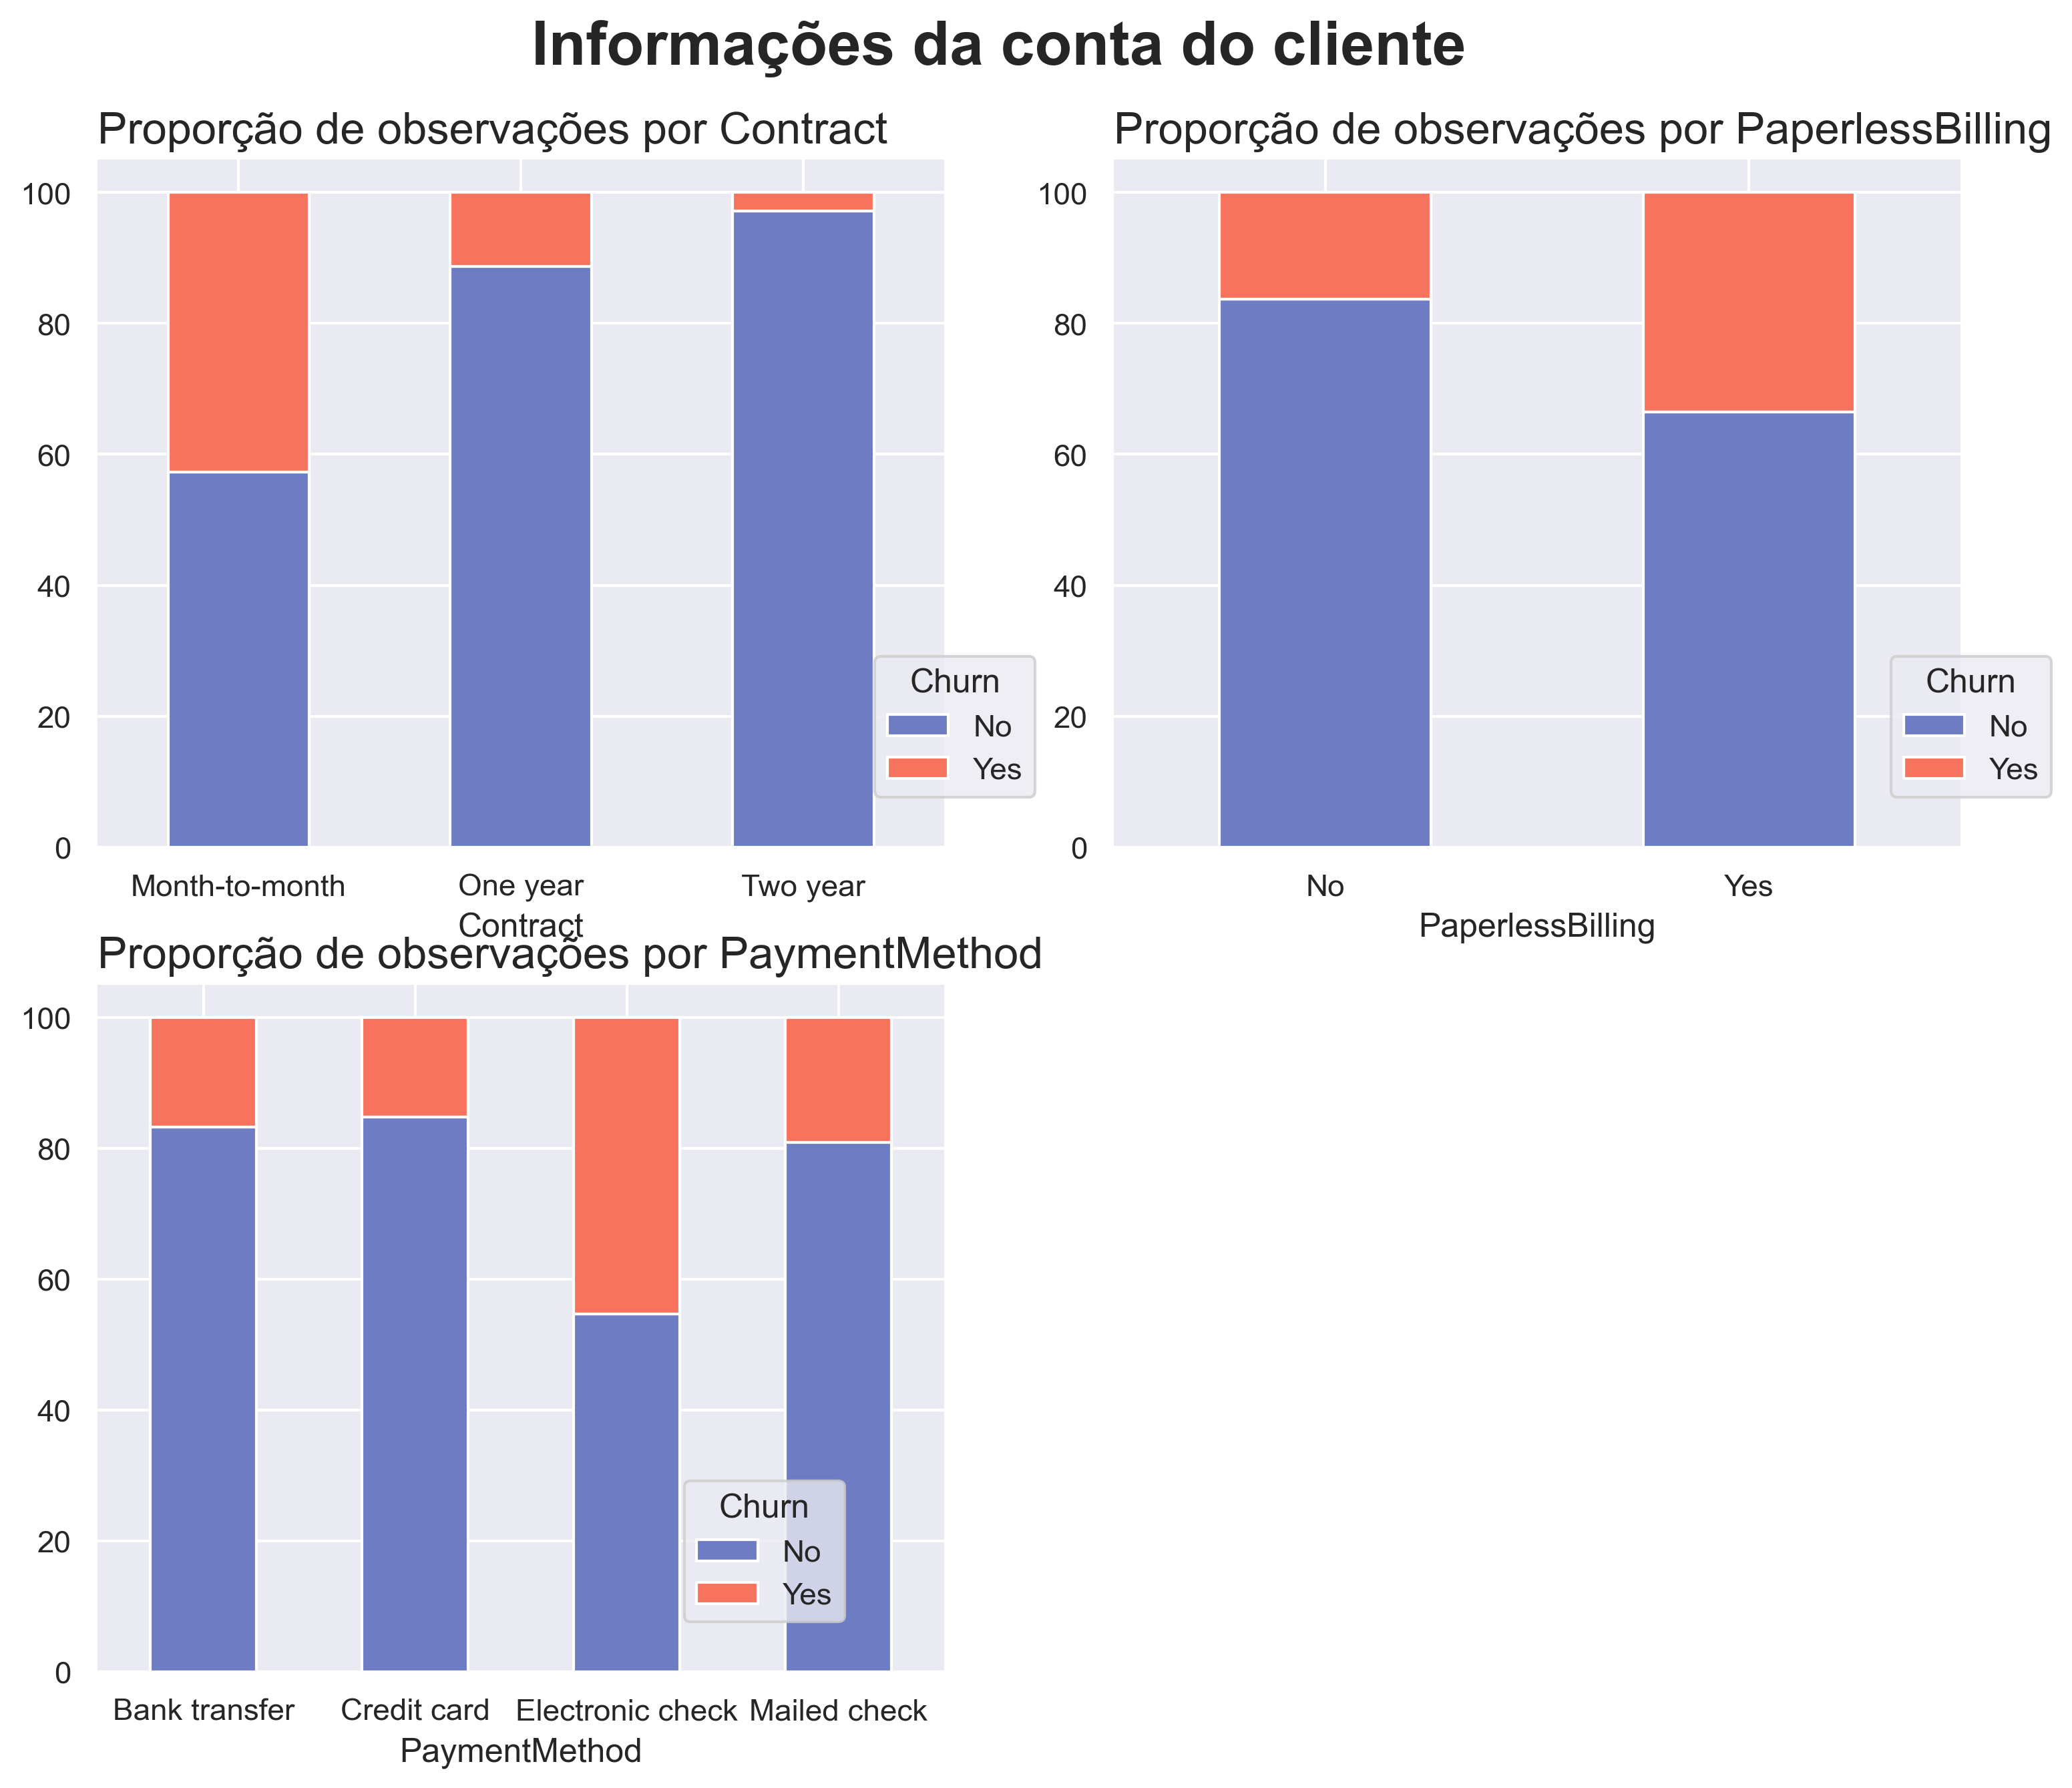

In [14]:

# customer account column names
account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Informações da conta do cliente')

In [15]:
def histogram_plots(columns_to_plot, super_title):
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows), dpi=300) 
    fig.suptitle(super_title, fontsize=22,  y=.95, weight='bold', horizontalalignment='right', x=0.50)


    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        df_telco[df_telco['Churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, label='No')
        df_telco[df_telco['Churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, label='Yes')

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribuição de ' + column + ' por churn',
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

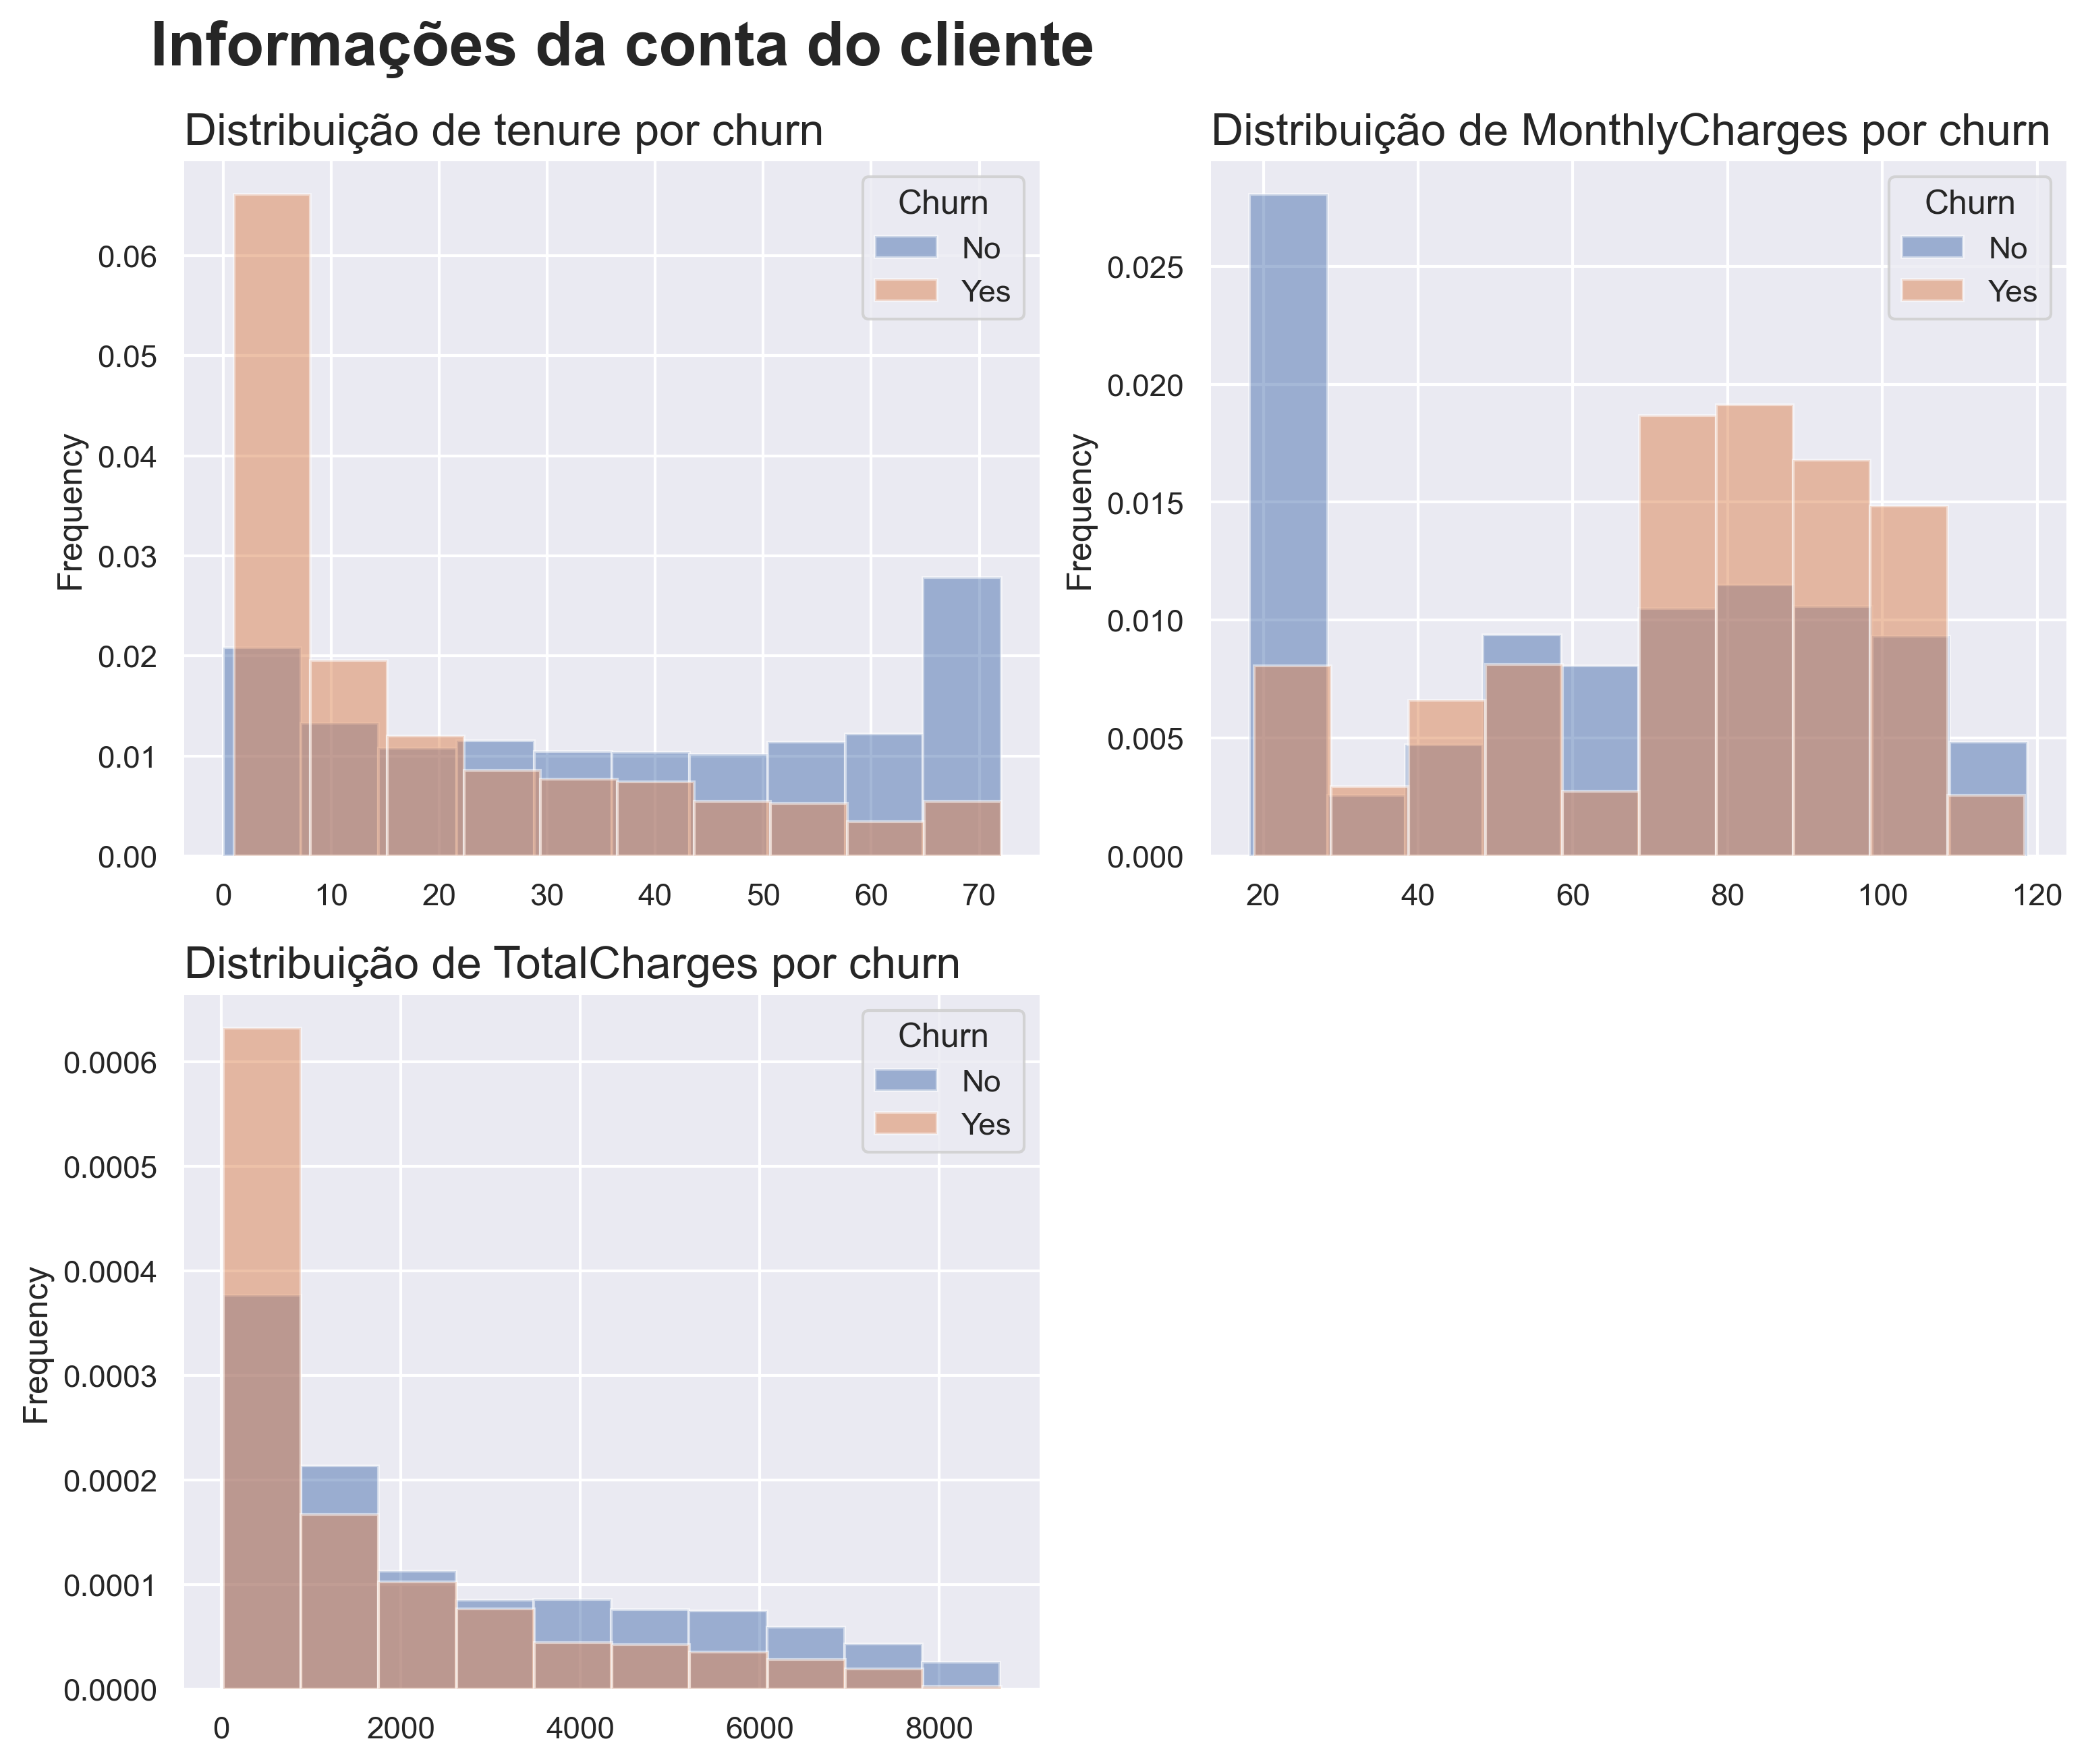

In [16]:
            
# customer account column names
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
# histogram of costumer account columns 
histogram_plots(account_columns_numeric, 'Informações da conta do cliente')

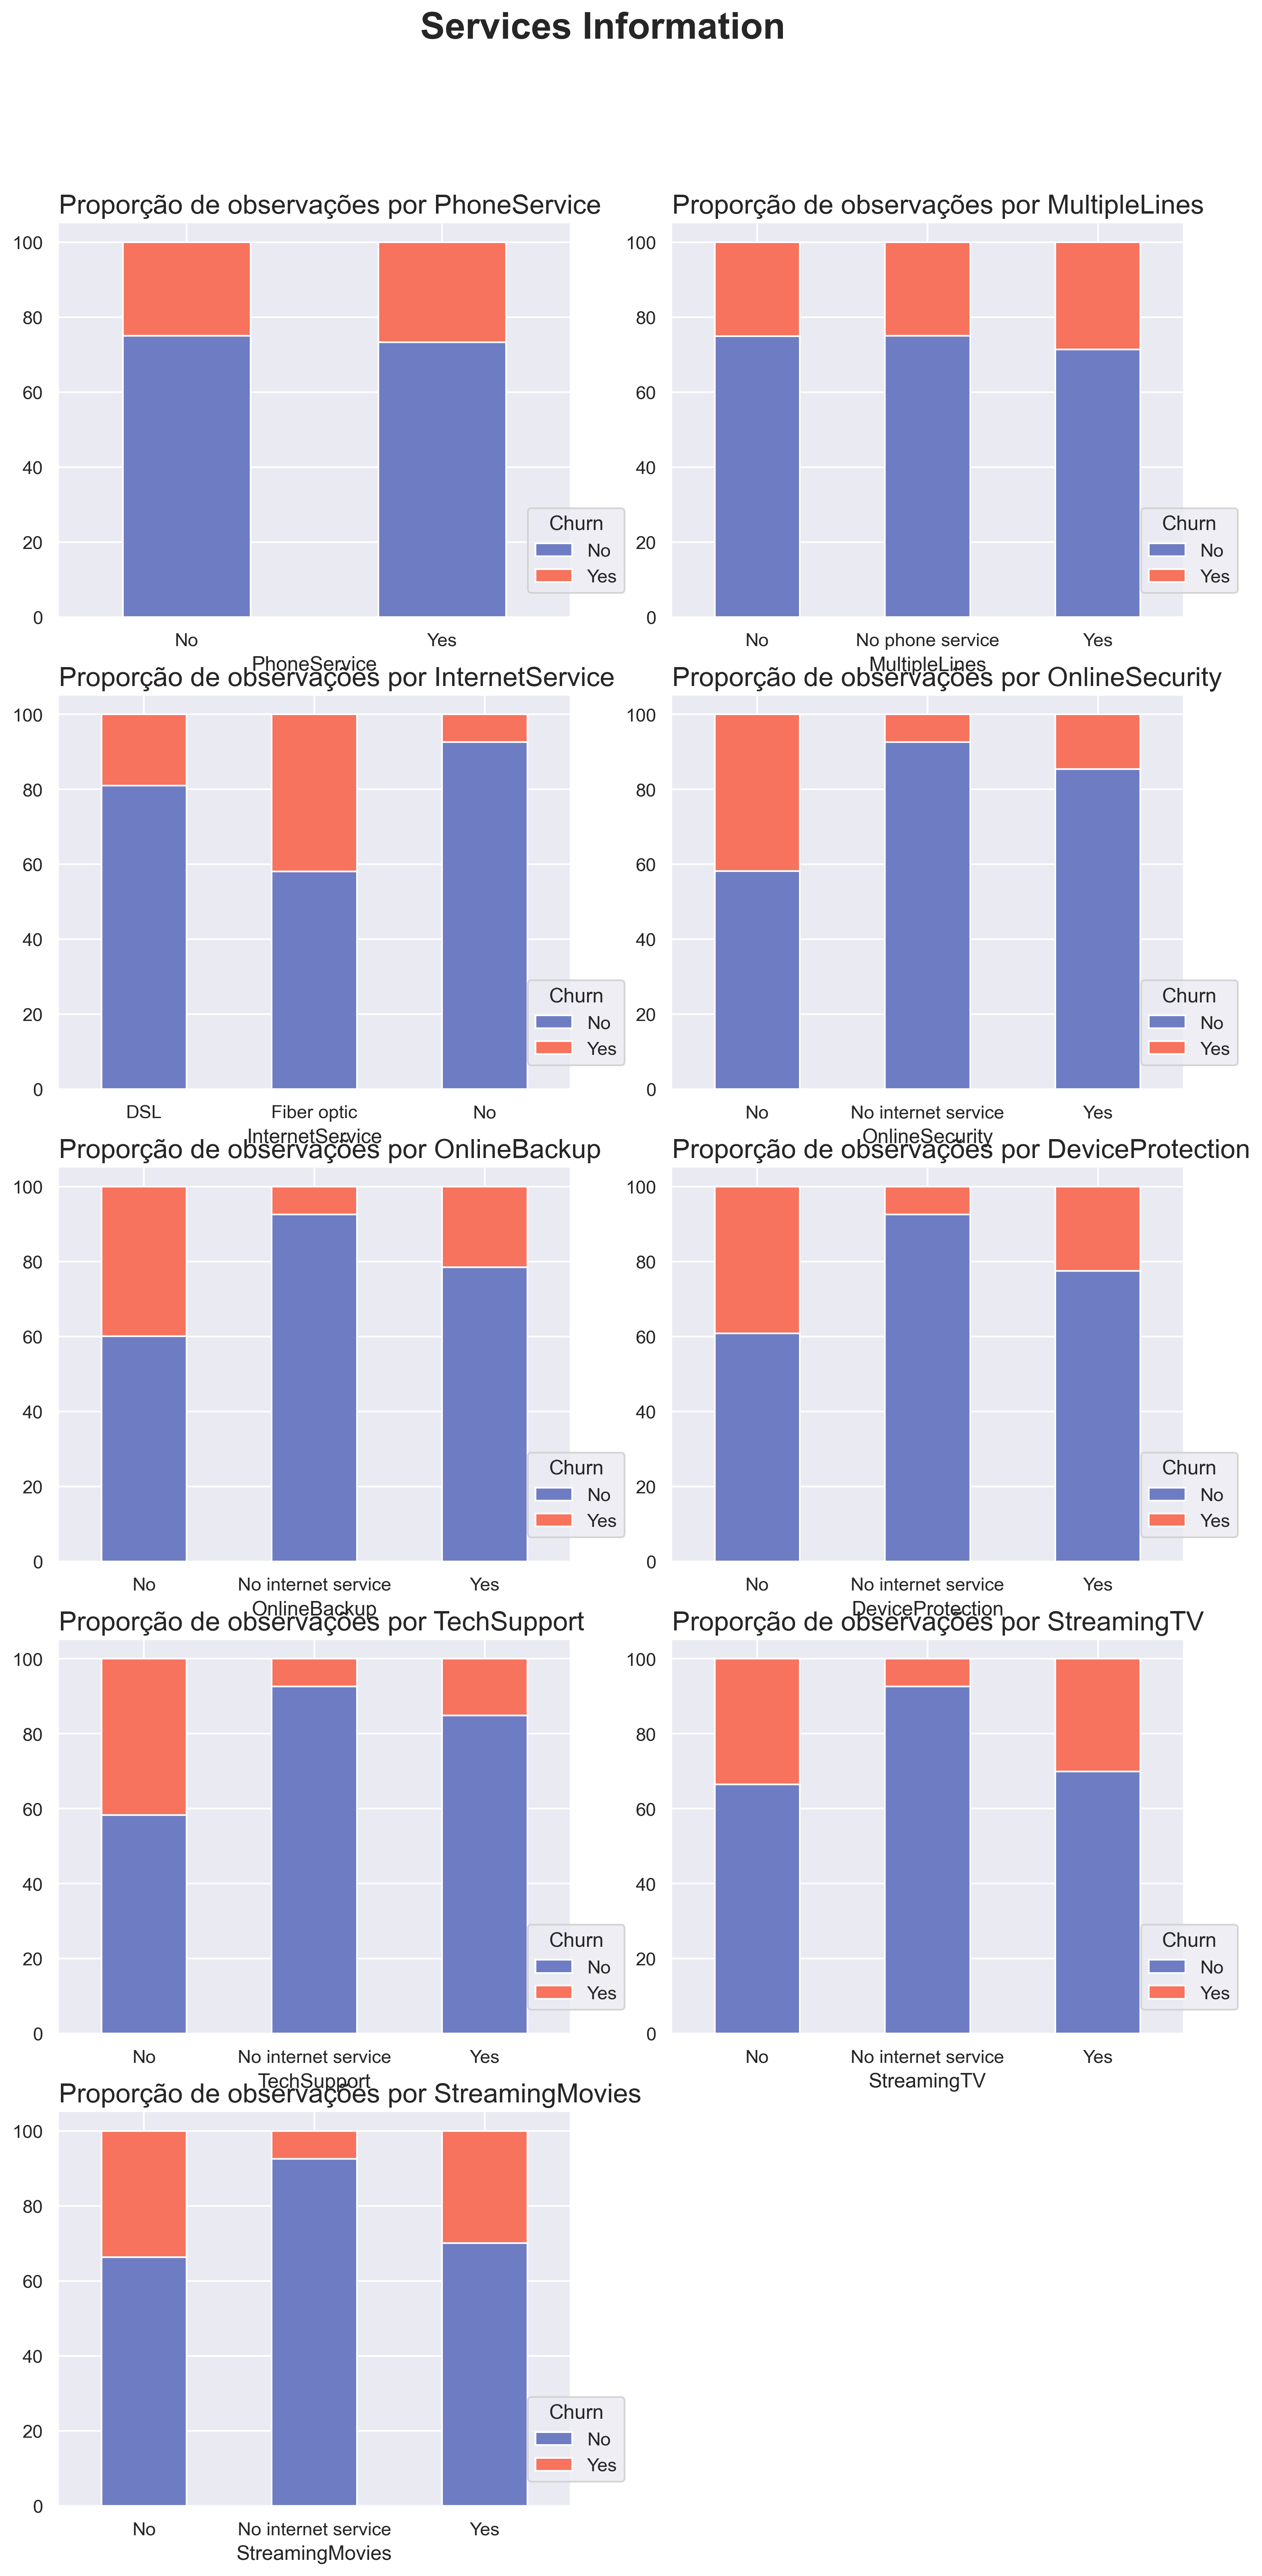

In [17]:
# services column names
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

In [18]:
df['PaperlessBilling']

0       Yes
1        No
2       Yes
3        No
4       Yes
       ... 
7038    Yes
7039    Yes
7040    Yes
7041    Yes
7042    Yes
Name: PaperlessBilling, Length: 7043, dtype: object

In [19]:
pd.crosstab(df['gender'], df['Churn']).apply(lambda x: x/x.sum(), axis=1).T

gender,Female,Male
Churn,,
No,0.730791,0.738397
Yes,0.269209,0.261603


In [20]:
df['gender']

0       Female
1         Male
2         Male
3         Male
4       Female
         ...  
7038      Male
7039    Female
7040    Female
7041      Male
7042      Male
Name: gender, Length: 7043, dtype: object

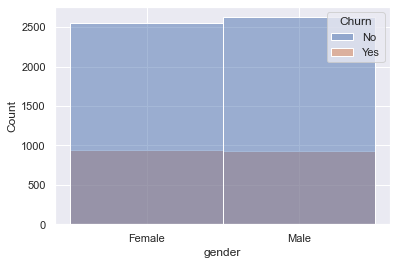

In [21]:
sns.histplot(data=df, x='gender', hue='Churn', color=sns.color_palette());
#plt.legend()